In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from data.data_model import DataModel
from models.double_mlp import DoubleMLPEstimator
from models.estimate import prop_dml, prop_dml_internal_stats
from tqdm.notebook import tqdm
from wrap.utils import np_to_torch, torch_to_np


p = 20
n = 200
rho = 0
theta = 10
lamb = 1

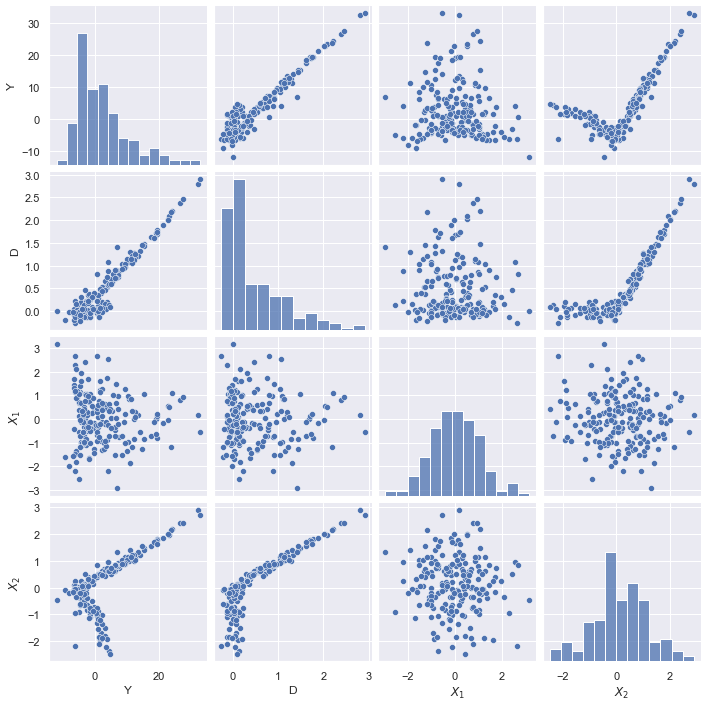

In [16]:
true_model = DataModel(p, rho, theta, lamb)

n_plot = 200
Y, D, X = true_model.generate(n_plot)
Y, D, X = torch_to_np(Y), torch_to_np(D), torch_to_np(X)

df = pd.DataFrame(data=np.concatenate((Y.reshape(n_plot, 1), D.reshape(n_plot, 1), X[:, 0:2]), 1), 
                  columns=['Y', 'D', '$X_1$', '$X_2$'])
sns.set(font_scale=1)
sns.pairplot(df)
sns.set(rc={'figure.figsize': (10, 10)})
plt.savefig('results/pairs_' + str(theta) + '_.pdf', bbox_inches="tight")
plt.show()

In [17]:
def run_experiments(theta, gammas, num_exp=10):
    lamb = 1
    df = pd.DataFrame()
    for gamma in tqdm(gammas):
        for i in range(num_exp):
            true_model = DataModel(p, rho, theta, lamb)
            Y, D, X = true_model.generate(n)
            dm, dl, theta_hat = prop_dml_internal_stats(Y, D, X, true_model, reg_labmda=gamma)
            va = (1 + theta ** 2) * (dm ** 2) + 1 * (dl ** 2) - 2 * theta * 1 * (dm * dl)
            df_tmp = pd.DataFrame({'model' : ['mlp'],
                                    'rho' : rho,
                                    'lamb' : lamb,
                                    'theta' : theta,
                                    'gamma' : gamma,
                                    'dm.2' : dm ** 2,
                                    'dl.2' : dl ** 2,
                                    'dm.dl': dm * dl,
                                    'dtheta' : theta_hat - theta,
                                    })
            df = pd.concat([df, df_tmp])
    
    return df

gammas = np.logspace(-5, 5, num=22)
df = run_experiments(theta, gammas, num_exp=100)
df_avg = df.groupby(['model', 'rho', 'gamma', 'theta']).mean().reset_index()

  0%|          | 0/22 [00:00<?, ?it/s]

In [18]:
def plot_results(df, axs, key):
    for gamma in gammas:
        df_tmp = df[df['gamma'] == gamma]
        df_tmp[key].plot.hist(alpha=0.5, ax=axs, label='{:.1e}'.format(gamma))     

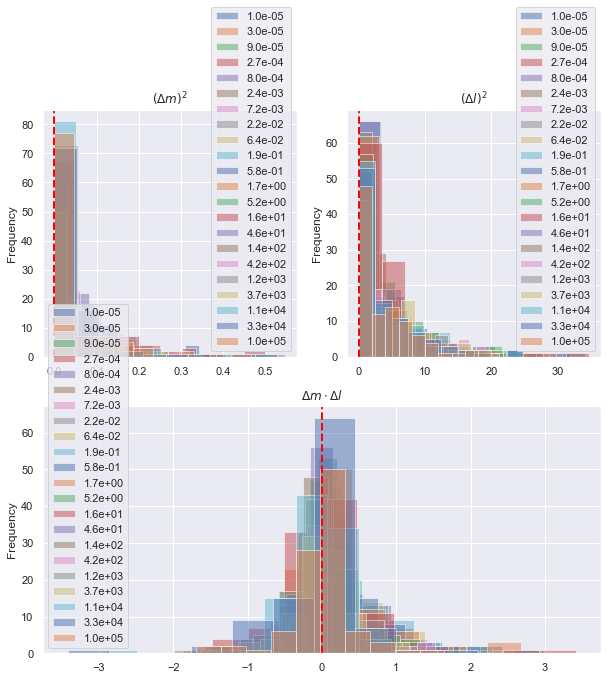

In [19]:
fig = plt.figure(figsize=(10,10))
grid = fig.add_gridspec(2, 2)

axs = fig.add_subplot(grid[0,0])
plot_results(df, axs, 'dm.2')
axs.set_title('$(\\Delta m)^2$')
axs.legend()
axs.axvline(x=0, linestyle='--', linewidth=2., color='red')

axs = fig.add_subplot(grid[0,1])
plot_results(df, axs, 'dl.2')
axs.set_title('$(\\Delta l)^2$')
axs.legend()
axs.axvline(x=0, linestyle='--', linewidth=2., color='red')

axs = fig.add_subplot(grid[1,:])
plot_results(df, axs, 'dm.dl')
axs.set_title('$\\Delta m \cdot \\Delta l$')
axs.legend()
axs.axvline(x=0, linestyle='--', linewidth=2., color='red')

plt.savefig('results/diagnostic_internal_' + str(theta) + '_.pdf', bbox_inches='tight')
plt.show()

In [20]:
def get_bias(df):
    bias = []
    for gamma in gammas:
        df_tmp = df[df['gamma'] == gamma]
        bias.append(df_tmp['dtheta'].mean())
    return np.asarray(bias)

def get_variance(df):
    variance = []
    for gamma in gammas:
        df_tmp = df[df['gamma'] == gamma]
        variance.append(df_tmp['dtheta'].var())
    return np.asarray(variance)

bias = get_bias(df) 
variance = get_variance(df)

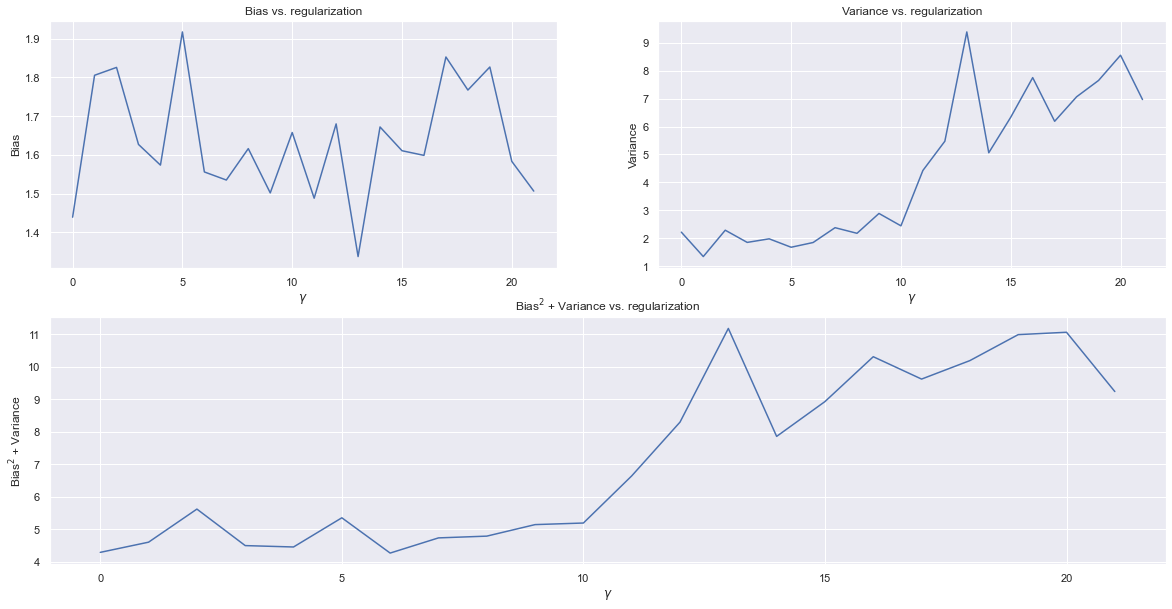

In [21]:
fig = plt.figure(figsize=(20,10))
grid = fig.add_gridspec(2, 2)

axs = fig.add_subplot(grid[0, 0])
axs.plot(bias)
axs.set_xlabel('$\\gamma$')
axs.set_ylabel('Bias')
axs.set_title('Bias vs. regularization')

axs = fig.add_subplot(grid[0, 1])
axs.plot(variance)
axs.set_xlabel('$\\gamma$')
axs.set_ylabel('Variance')
axs.set_title('Variance vs. regularization')


axs = fig.add_subplot(grid[1, :])
axs.plot(bias ** 2 + variance)
axs.set_xlabel('$\\gamma$')
axs.set_ylabel('Bias$^2$ + Variance')
axs.set_title('Bias$^2$ + Variance vs. regularization')

plt.savefig('results/diagnostic_external_' + str(theta) + '_.pdf', bbox_inches='tight')
plt.show()